In [12]:
import sys
import os
sys.path.append('..')
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.optim.adam import Adam
import torchaudio

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [14]:
class asd(Dataset):
    def __init__(self, data_folder: str, samplerate: int = 3000) -> None:
        self.file_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder)]
        self.file_paths = self.file_paths[:100]
        self.samplerate = samplerate
    

    def __len__(self) -> int:
        return len(self.file_paths)
    

    def __getitem__(self, idx: int) -> torch.tensor:
        item_path = self.file_paths[idx]
        waveform, samplerate = torchaudio.load(item_path)
        
        resampler = torchaudio.transforms.Resample(
            orig_freq=samplerate,
            new_freq=self.samplerate
        )

        downsampled_waveform = resampler(waveform)
        return downsampled_waveform

In [15]:
x = asd('../data')
x[99].shape

torch.Size([2, 32921])

In [16]:
class LoFiDataset(Dataset):
    def __init__(self, data_folder: str, samplerate: int = 3000) -> None:
        self.file_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder)]
        self.samplerate = samplerate
    

    def __len__(self) -> int:
        return len(self.file_paths)
    

    def __getitem__(self, idx: int) -> torch.tensor:
        item_path = self.file_paths[idx]
        waveform, samplerate = torchaudio.load(item_path)
        
        resampler = torchaudio.transforms.Resample(
            orig_freq=samplerate,
            new_freq=self.samplerate
        )

        downsampled_waveform = resampler(waveform)
        return downsampled_waveform.mean(axis=0)

In [17]:
dataset = LoFiDataset('../data')

In [18]:
batch_size = 32
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [19]:
class VAE(nn.Module):
    def __init__(self, input_dim=32921, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [20]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_function = torch.nn.KLDivLoss()

In [21]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/((batch_idx+1)*batch_size))
    return overall_loss

In [22]:
train(model, optimizer, epochs=200, device=device)

/home/diego/miniconda3/envs/amaprob/lib/python3.11/site-packages/torch/nn/functional.py:3369: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


	Epoch 1 	Average Loss:  -0.011234419187530875
	Epoch 2 	Average Loss:  -0.011476762127131224
	Epoch 3 	Average Loss:  -0.011486693595846495
	Epoch 4 	Average Loss:  -0.01149513052466015
	Epoch 5 	Average Loss:  -0.011496620951220393
	Epoch 6 	Average Loss:  -0.011496975164239606
	Epoch 7 	Average Loss:  -0.011497877150153121
	Epoch 8 	Average Loss:  -0.011499949498102069
	Epoch 9 	Average Loss:  -0.011500997158388296
	Epoch 10 	Average Loss:  -0.011501961077253023
	Epoch 11 	Average Loss:  -0.01150392492612203
	Epoch 12 	Average Loss:  -0.011505515159418186
	Epoch 13 	Average Loss:  -0.01150654962596794
	Epoch 14 	Average Loss:  -0.011507736286148429
	Epoch 15 	Average Loss:  -0.011507748626172543
	Epoch 16 	Average Loss:  -0.011508698963249723
	Epoch 17 	Average Loss:  -0.011509893850112954
	Epoch 18 	Average Loss:  -0.01151126530021429
	Epoch 19 	Average Loss:  -0.011511452418441573
	Epoch 20 	Average Loss:  -0.01151174531939129
	Epoch 21 	Average Loss:  -0.011510780934865275
	Epoch

KeyboardInterrupt: 

In [23]:
from random import random
def generate_coord():
    return 4*random() - 2

In [24]:
def generate_song(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    return x_decoded

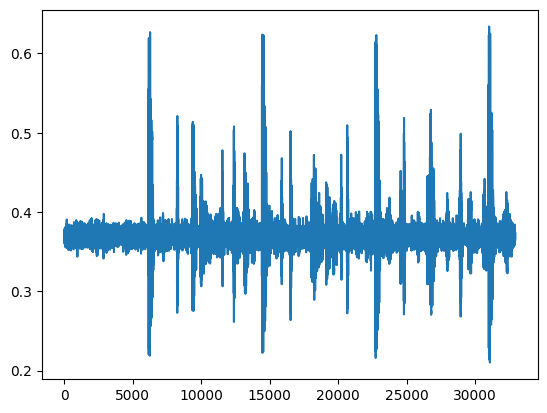

In [50]:
a = generate_song(generate_coord(), generate_coord())
b = torch.cat([a, a], dim=0)
b = b.detach().to('cpu')
torchaudio.save('asd.wav', b, 3000)
plt.plot(b[0])

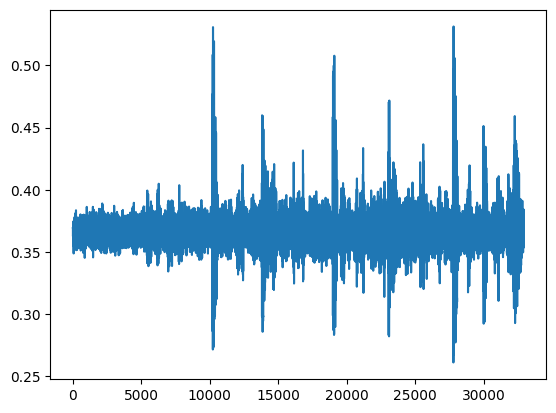